In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_val_Images.pkl
/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_train_Images.pkl
/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_train_Masks.pkl
/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_val_Masks.pkl


In [2]:
# ==================== COMPLETE GPU/CUDA FIX ====================
import os
import gc
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# STEP 1: Clean up any existing sessions and memory
print("=== CLEANING UP MEMORY ===")
K.clear_session()
gc.collect()

# STEP 2: Configure CUDA and GPU
print("\n=== CONFIGURING CUDA AND GPU ===")

# Set CUDA environment variables
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_VISIBLE_DEVICES"]='0,1'

# Configure GPU with proper memory management
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Method 1: Set memory growth (prevents pre-allocation)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Method 2: Limit GPU memory (uncomment if needed)
        # tf.config.experimental.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15360)]
        # )
        
        print(f"✓ Found {len(gpus)} GPU(s)")
        print(f"✓ GPU: {gpus[0].name}")
        
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

# STEP 3: Verify CUDA
print("\n=== CUDA VERIFICATION ===")
print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA built with TF: {tf.test.is_built_with_cuda()}")
print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

# Show CUDA version
!nvcc --version
!nvidia-smi

# STEP 4: Test GPU with small operation
print("\n=== TESTING GPU ===")
try:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print(f"✓ GPU test successful: {c.shape}")
except Exception as e:
    print(f"✗ GPU test failed: {e}")


2025-10-24 12:45:11.097874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761309911.338596      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761309911.409412      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


=== CLEANING UP MEMORY ===

=== CONFIGURING CUDA AND GPU ===
✓ Found 2 GPU(s)
✓ GPU: /physical_device:GPU:0

=== CUDA VERIFICATION ===
TensorFlow version: 2.18.0
CUDA built with TF: True
GPU available: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


I0000 00:00:1761309925.255182      37 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761309925.256016      37 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Fri Oct 24 12:45:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             26W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

I0000 00:00:1761309925.655832      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761309925.656110      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [75]:
# Set global float32 policy
tf.keras.backend.set_floatx('float32')
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [76]:
# ==================== PART 2: LOAD DATA ====================
# ======================CYTOPLASM==========================
from sklearn.model_selection import train_test_split
print("\n=== Loading Data ===")

# Load pickle files
with open('/kaggle/input/cytoplasm/train_pickles/images.pkl', 'rb') as f:
    images_train_full = pickle.load(f)

with open('/kaggle/input/cytoplasm/train_pickles/masks.pkl', 'rb') as f:
    masks_train_full = pickle.load(f)

with open('/kaggle/input/cytoplasm/test_pickles/images_test.pkl', 'rb') as f:
    images_test = pickle.load(f)

with open('/kaggle/input/cytoplasm/test_pickles/masks_test_cyto_clump.pkl', 'rb') as f:
    masks_test = pickle.load(f)



test_size_ratio = 0.2
SEED = 42 

images_train, images_val, masks_train, masks_val = train_test_split(
    images_train_full, 
    masks_train_full, 
    test_size=test_size_ratio, 
    random_state=SEED
)

print(f"Training data shape - Images: {images_train.shape}, Masks: {masks_train.shape}")
print(f"Validation data shape - Images: {images_val.shape}, Masks: {masks_val.shape}")


# --- Preprocessing (Normalization and One-Hot Encoding) ---
# Normalize images to [0,1]
X_train = images_train.astype('float32') 
X_val = images_val.astype('float32') 
X_test = images_test.astype('float32') 

# Convert masks to categorical (one-hot encoding) for num_classes=2
num_classes = 2 
y_train = tf.keras.utils.to_categorical(masks_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(masks_val, num_classes=num_classes) # Preprocess validation masks
y_test = tf.keras.utils.to_categorical(masks_test, num_classes=num_classes)

print(f"\nAfter preprocessing:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}") # Changed to X_val, y_val
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Unique values in masks (test set): {np.unique(masks_test)}")

print(f"Training data shape - Images: {images_train.shape}, Masks: {masks_train.shape}")
print(f"Validation data shape - Images: {images_val.shape}, Masks: {masks_val.shape}")

# # Normalize images to [0,1]
# X_train = images_train.astype('float32') / 255.0
# X_test = images_test.astype('float32') / 255.0

# # Convert masks to categorical (one-hot encoding) for num_classes=2
# y_train = tf.keras.utils.to_categorical(masks_train, num_classes=2)
# y_test = tf.keras.utils.to_categorical(masks_test, num_classes=2)

# print(f"\nAfter preprocessing:")
# print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"X_val: {X_test.shape}, y_val: {y_test.shape}")
# print(f"Unique values in masks: {np.unique(masks_test)}")


=== Loading Data ===
Training data shape - Images: (320, 512, 512, 3), Masks: (320, 512, 512)
Validation data shape - Images: (80, 512, 512, 3), Masks: (80, 512, 512)

After preprocessing:
X_train: (320, 512, 512, 3), y_train: (320, 512, 512, 2)
X_val: (80, 512, 512, 3), y_val: (80, 512, 512, 2)
X_test: (100, 512, 512, 3), y_test: (100, 512, 512, 2)
Unique values in masks (test set): [0 1]
Training data shape - Images: (320, 512, 512, 3), Masks: (320, 512, 512)
Validation data shape - Images: (80, 512, 512, 3), Masks: (80, 512, 512)


In [77]:
# Check the shape of a single image
print(f"Shape of a single image: {X_val[0].shape}")
# Run this outside of your plotting loop on the X_val array:
image_to_check = X_val[0]

print("\n--- Data Inspection ---")
print(f"Minimum pixel value: {np.min(image_to_check)}")
print(f"Maximum pixel value: {np.max(image_to_check)}")
print(f"Mean pixel value: {np.mean(image_to_check)}")

Shape of a single image: (512, 512, 3)

--- Data Inspection ---
Minimum pixel value: 0.07058823853731155
Maximum pixel value: 1.0
Mean pixel value: 0.7660026550292969



--- Visualizing 5 Validation Image-Mask Pairs ---


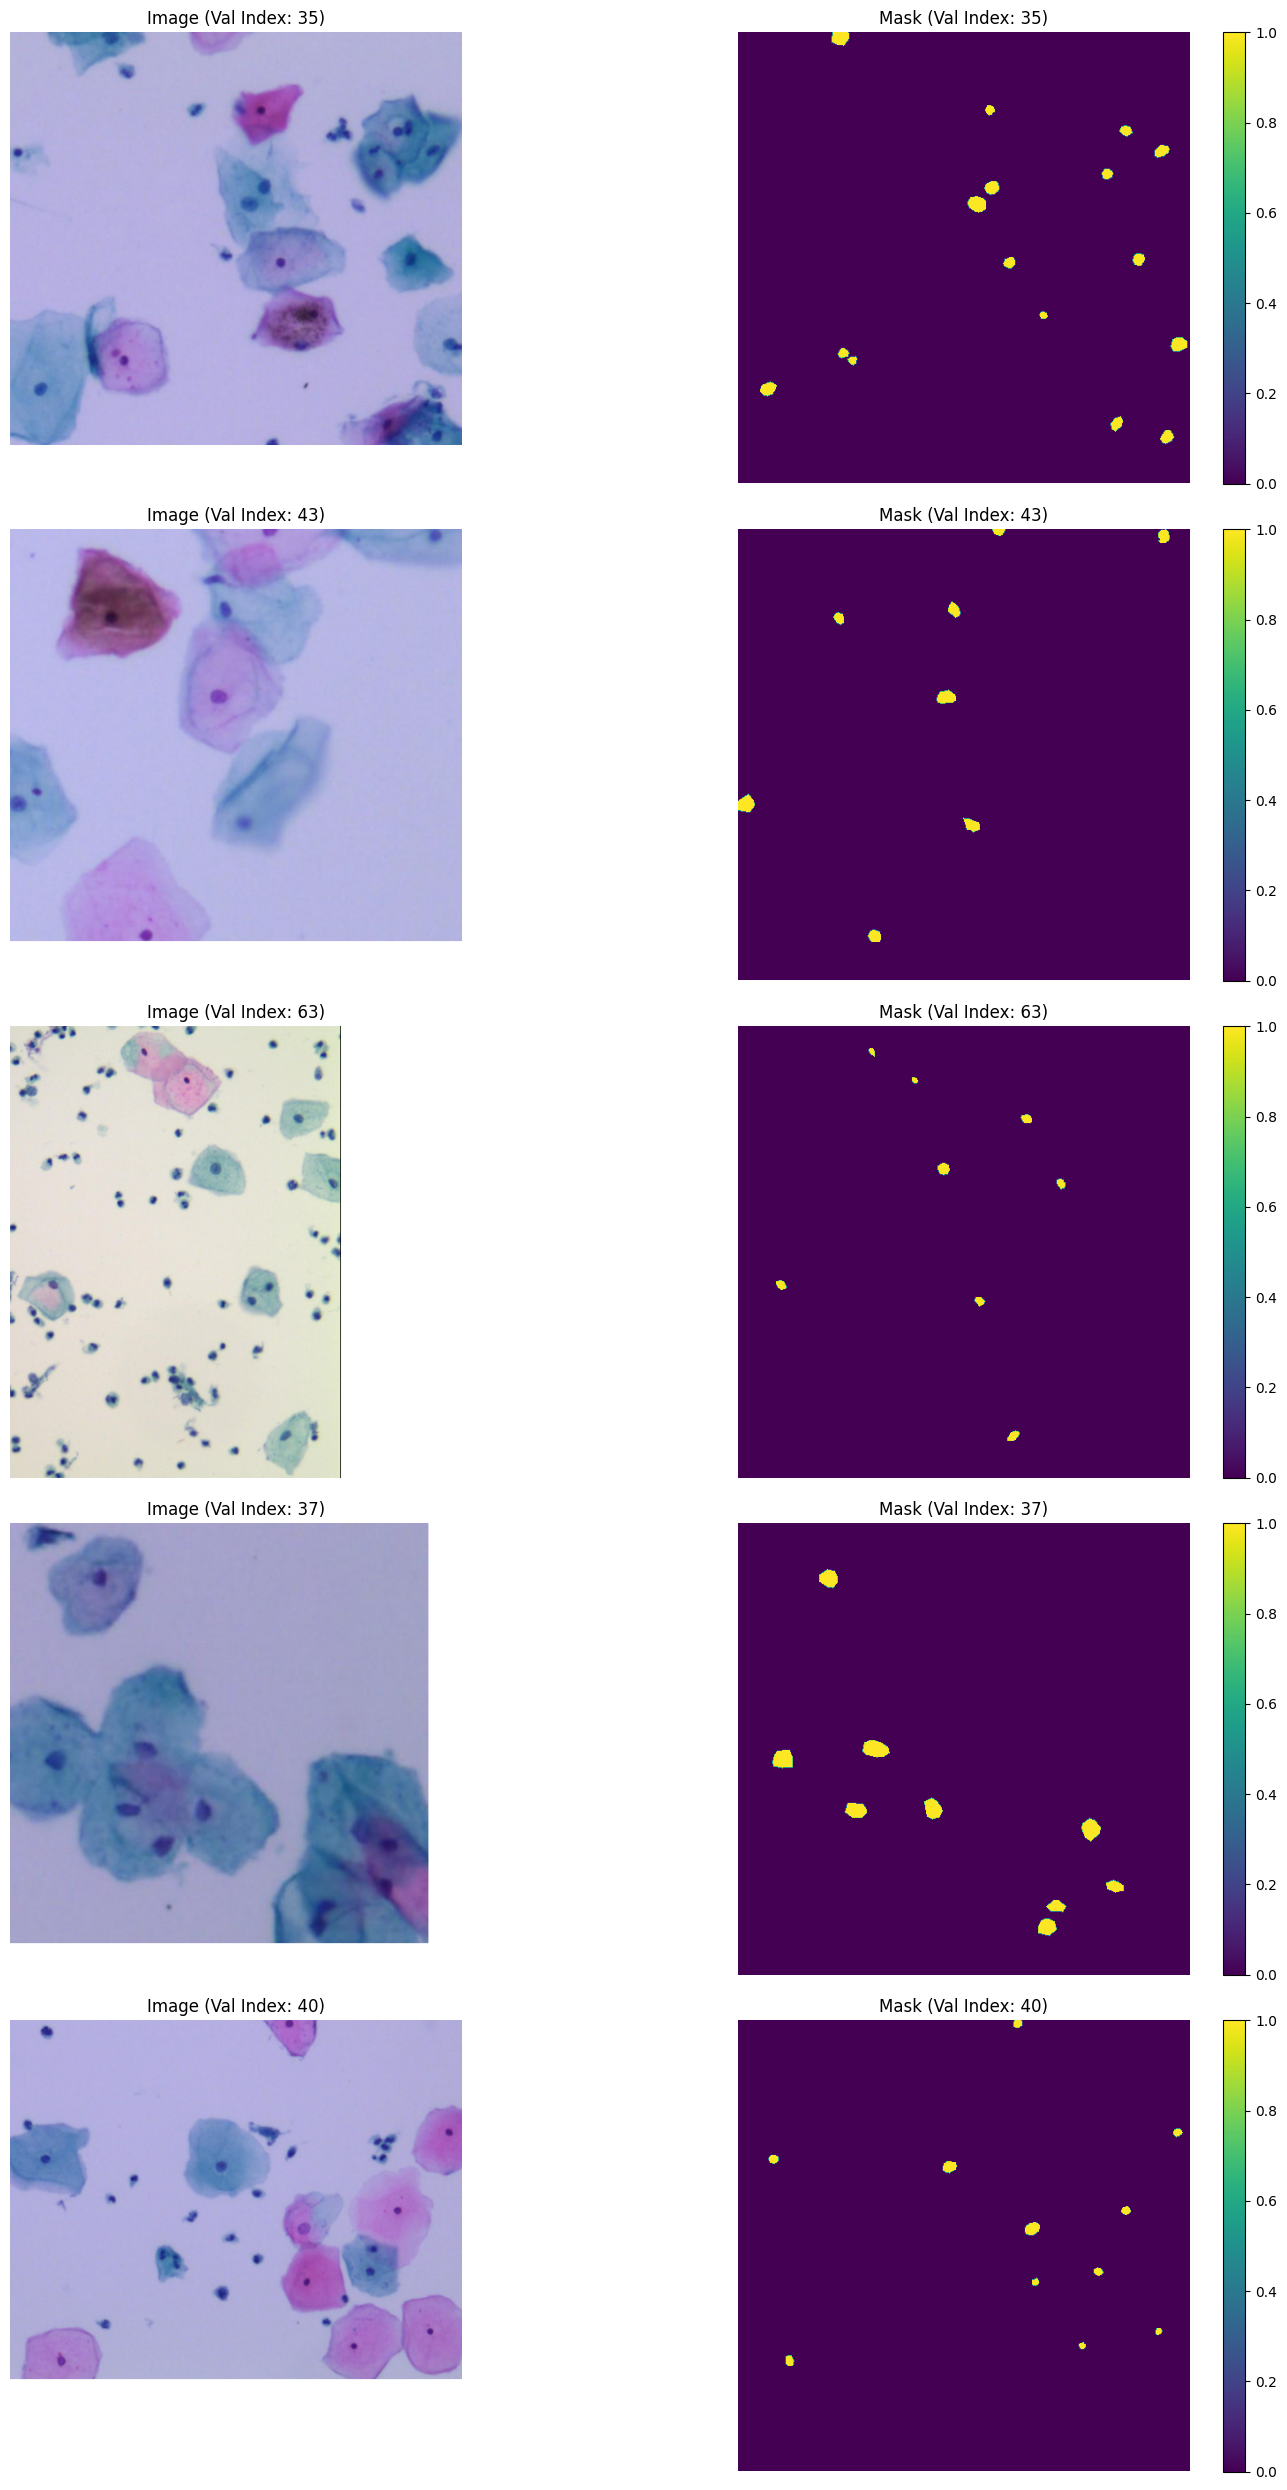

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_val_data(X_val, y_val, num_samples=5):
    """
    Visualizes image and mask pairs from the validation set to ensure they match.
    """
    print(f"\n--- Visualizing {num_samples} Validation Image-Mask Pairs ---")

    # Get random indices to sample
    indices = np.random.choice(X_val.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        # 1. Get the image
        img = X_val[idx]

        # 2. Convert the one-hot mask back to a categorical mask
        mask_one_hot = y_val[idx]
        mask_categorical = np.argmax(mask_one_hot, axis=-1)

        # Plot the Image
        plt.subplot(num_samples, 2, 2 * i + 1)
        
        # FIX: Explicitly set vmin and vmax to the normalized range [0.0, 1.0]
        # This tells matplotlib how to map the float values to colors.
        plt.imshow(img, vmin=0.0, vmax=1.0) 
        
        plt.title(f"Image (Val Index: {idx})")
        plt.axis('off')

        # Plot the Mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        # Use a colormap to clearly distinguish the two classes (0 and 1)
        plt.imshow(mask_categorical, cmap='viridis')
        plt.title(f"Mask (Val Index: {idx})")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# You would call this function after defining X_val and y_val
visualize_val_data(X_val, y_val, num_samples=5)

In [88]:
# ==================== PART 2: LOAD DATA ====================
print("\n=== Loading Data ===")

# Load pickle files
with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_train_Images.pkl', 'rb') as f:
    images_train = pickle.load(f)

with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_train_Masks.pkl', 'rb') as f:
    masks_train = pickle.load(f)

with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_val_Images.pkl', 'rb') as f:
    images_val = pickle.load(f)

with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_val_Masks.pkl', 'rb') as f:
    masks_val = pickle.load(f)

print(f"Training data shape - Images: {images_train.shape}, Masks: {masks_train.shape}")
print(f"Validation data shape - Images: {images_val.shape}, Masks: {masks_val.shape}")

# # Normalize images to [0,1]
# X_train = images_train.astype('float32') / 255.0
# X_val = images_val.astype('float32') / 255.0

# Normalize images to [0,1]
X_train = images_train.astype('float32')
X_val = images_val.astype('float32')

# Convert masks to categorical (one-hot encoding) for num_classes=2
y_train = tf.keras.utils.to_categorical(masks_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(masks_val, num_classes=2)

print(f"\nAfter preprocessing:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Unique values in masks: {np.unique(masks_train)}")


=== Loading Data ===
Training data shape - Images: (320, 512, 512, 3), Masks: (320, 512, 512)
Validation data shape - Images: (80, 512, 512, 3), Masks: (80, 512, 512)

After preprocessing:
X_train: (320, 512, 512, 3), y_train: (320, 512, 512, 2)
X_val: (80, 512, 512, 3), y_val: (80, 512, 512, 2)
Unique values in masks: [0 1]


In [89]:
# Check the shape of a single image
print(f"Shape of a single image: {X_val[0].shape}")
# Run this outside of your plotting loop on the X_val array:
image_to_check = X_val[0]

print("\n--- Data Inspection ---")
print(f"Minimum pixel value: {np.min(image_to_check)}")
print(f"Maximum pixel value: {np.max(image_to_check)}")
print(f"Mean pixel value: {np.mean(image_to_check)}")

Shape of a single image: (512, 512, 3)

--- Data Inspection ---
Minimum pixel value: 0.1921568661928177
Maximum pixel value: 1.0
Mean pixel value: 0.8568706512451172


In [90]:
# ==================== PART 3: METRICS DEFINITION ====================
print("\n=== Defining Metrics ===")

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculate Dice coefficient for binary segmentation"""
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true[..., 1])  # Use class 1 (foreground)
    y_pred_f = K.flatten(y_pred[..., 1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for optimization"""
    return 1 - dice_coefficient(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    """Calculate IoU (Intersection over Union) score"""
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true[..., 1])
    y_pred_f = K.flatten(y_pred[..., 1])
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
def true_positive_rate(y_true, y_pred, threshold=0.5):
    """
    Calculate True Positive Rate (TPR) / Sensitivity / Recall
    TPR = TP / (TP + FN)
    """
    # Get predictions for foreground class
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_pred_pos = K.flatten(y_pred[..., 1])
    y_true_pos = K.flatten(y_true[..., 1])
    
    # Threshold predictions
    y_pred_pos = K.cast(K.greater(y_pred_pos, threshold), K.floatx())
    y_true_pos = K.cast(y_true_pos, K.floatx())
    
    # Calculate True Positives and False Negatives
    true_positives = K.sum(y_true_pos * y_pred_pos)
    false_negatives = K.sum(y_true_pos * (1 - y_pred_pos))
    
    tpr = true_positives / (true_positives + false_negatives + K.epsilon())
    return tpr

def false_positive_rate(y_true, y_pred, threshold=0.5):
    """
    Calculate False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    """
    # Get predictions for foreground class
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_pred_pos = K.flatten(y_pred[..., 1])
    y_true_pos = K.flatten(y_true[..., 1])
    
    # Threshold predictions
    y_pred_pos = K.cast(K.greater(y_pred_pos, threshold), K.floatx())
    y_true_pos = K.cast(y_true_pos, K.floatx())
    
    # Calculate False Positives and True Negatives
    false_positives = K.sum((1 - y_true_pos) * y_pred_pos)
    true_negatives = K.sum((1 - y_true_pos) * (1 - y_pred_pos))
    
    fpr = false_positives / (false_positives + true_negatives + K.epsilon())
    return fpr

def precision(y_true, y_pred, threshold=0.5):
    """
    Calculate Precision
    Precision = TP / (TP + FP)
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_pred_pos = K.flatten(y_pred[..., 1])
    y_true_pos = K.flatten(y_true[..., 1])
    
    y_pred_pos = K.cast(K.greater(y_pred_pos, threshold), K.floatx())
    y_true_pos = K.cast(y_true_pos, K.floatx())
    
    true_positives = K.sum(y_true_pos * y_pred_pos)
    false_positives = K.sum((1 - y_true_pos) * y_pred_pos)
    
    precision_val = true_positives / (true_positives + false_positives + K.epsilon())
    return precision_val

def specificity(y_true, y_pred, threshold=0.5):
    """
    Calculate Specificity (True Negative Rate)
    Specificity = TN / (TN + FP)
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_pred_pos = K.flatten(y_pred[..., 1])
    y_true_pos = K.flatten(y_true[..., 1])
    
    y_pred_pos = K.cast(K.greater(y_pred_pos, threshold), K.floatx())
    y_true_pos = K.cast(y_true_pos, K.floatx())
    
    true_negatives = K.sum((1 - y_true_pos) * (1 - y_pred_pos))
    false_positives = K.sum((1 - y_true_pos) * y_pred_pos)
    
    specificity_val = true_negatives / (true_negatives + false_positives + K.epsilon())
    return specificity_val


# Additional metric for overall performance
def f1_score(y_true, y_pred, threshold=0.5):
    """
    Calculate F1 Score (harmonic mean of precision and recall)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    """
    prec = precision(y_true, y_pred, threshold)
    rec = true_positive_rate(y_true, y_pred, threshold)
    
    f1 = 2 * (prec * rec) / (prec + rec + K.epsilon())
    return f1


def combined_loss(y_true, y_pred):
    """Combined loss: BCE + Dice loss for better optimization"""
    bce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


=== Defining Metrics ===


## MULTI RES UNET

In [91]:
# ==================== PART 4: MODEL ARCHITECTURE ====================
print("\n=== Building MultiResUNet Model ===")

def conv_block(x, filters, kernel_size=3, padding='same', activation=True, name_prefix=''):
    """Convolution + BatchNorm + ReLU block"""
    x = layers.Conv2D(filters, kernel_size, padding=padding, 
                      kernel_initializer='he_normal', 
                      name=f'{name_prefix}_conv')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn')(x)
    if activation:
        x = layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    return x

def MultiRes_block(x, filters, alpha=1.67, name_prefix=''):
    """MultiRes block with multiple filter sizes"""
    print(f"  Creating MultiRes block: input shape={x.shape}, filters={filters}")
    
    W = int(alpha * filters)
    w1 = int(W * 0.167) + 1
    w2 = int(W * 0.333) + 1
    w3 = int(W * 0.5) + 1
    out_filters = w1 + w2 + w3
    
    # Branch 1: 3x3 conv
    conv3x3 = conv_block(x, w1, 3, name_prefix=f'{name_prefix}_3x3')
    
    # Branch 2: 3x3 -> 3x3 (simulating 5x5)
    conv5x5 = conv_block(conv3x3, w2, 3, name_prefix=f'{name_prefix}_5x5')
    
    # Branch 3: 3x3 -> 3x3 (simulating 7x7)
    conv7x7 = conv_block(conv5x5, w3, 3, name_prefix=f'{name_prefix}_7x7')
    
    # Concatenate all branches
    concat = layers.concatenate([conv3x3, conv5x5, conv7x7], name=f'{name_prefix}_concat')
    concat = layers.BatchNormalization(name=f'{name_prefix}_concat_bn')(concat)
    
    # Residual connection
    shortcut = conv_block(x, out_filters, 1, activation=False, name_prefix=f'{name_prefix}_shortcut')
    
    # Add residual
    output = layers.add([concat, shortcut], name=f'{name_prefix}_add')
    output = layers.Activation('relu', name=f'{name_prefix}_final_relu')(output)
    output = layers.BatchNormalization(name=f'{name_prefix}_final_bn')(output)
    
    print(f"  MultiRes block output shape: {output.shape}")
    return output

def ResPath(x, filters, length, name_prefix=''):
    """Residual path with specified length"""
    print(f"  Creating ResPath: length={length}, filters={filters}")
    
    for i in range(length):
        # First conv
        shortcut = x
        x = conv_block(x, filters, 3, name_prefix=f'{name_prefix}_block{i}_conv1')
        x = conv_block(x, filters, 1, activation=False, name_prefix=f'{name_prefix}_block{i}_conv2')
        
        # Adjust shortcut if needed
        if shortcut.shape[-1] != filters:
            shortcut = conv_block(shortcut, filters, 1, activation=False, 
                                name_prefix=f'{name_prefix}_block{i}_shortcut')
        
        # Add and activate
        x = layers.add([x, shortcut], name=f'{name_prefix}_block{i}_add')
        x = layers.Activation('relu', name=f'{name_prefix}_block{i}_relu')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_block{i}_bn')(x)
    
    return x

def build_multiresunet(input_shape=(None, None, 3), num_classes=2):
    """Build MultiResUNet model using functional API"""
    print(f"\nBuilding model with input_shape={input_shape}, num_classes={num_classes}")
    
    # Input
    inputs = layers.Input(shape=input_shape, name='input')
    print(f"Input layer shape: {inputs.shape}")
    
    # Filter sizes for each level
    filters = [32, 64, 128, 256, 512]
    
    # Encoder Path
    print("\n--- ENCODER PATH ---")
    
    # Level 1
    mresblock1 = MultiRes_block(inputs, filters[0], name_prefix='enc1')
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(mresblock1)
    
    # Level 2
    mresblock2 = MultiRes_block(pool1, filters[1], name_prefix='enc2')
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool2')(mresblock2)
    
    # Level 3
    mresblock3 = MultiRes_block(pool2, filters[2], name_prefix='enc3')
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), name='pool3')(mresblock3)
    
    # Level 4
    mresblock4 = MultiRes_block(pool3, filters[3], name_prefix='enc4')
    pool4 = layers.MaxPooling2D(pool_size=(2, 2), name='pool4')(mresblock4)
    
    # Bridge
    print("\n--- BRIDGE ---")
    mresblock5 = MultiRes_block(pool4, filters[4], name_prefix='bridge')
    
    # Decoder Path with ResPath
    print("\n--- DECODER PATH ---")
    
    # Level 4
    up4 = layers.UpSampling2D(size=(2, 2), name='up4')(mresblock5)
    respath4 = ResPath(mresblock4, filters[3], 1, name_prefix='respath4')
    concat4 = layers.concatenate([up4, respath4], name='concat4')
    mresblock6 = MultiRes_block(concat4, filters[3], name_prefix='dec4')
    
    # Level 3
    up3 = layers.UpSampling2D(size=(2, 2), name='up3')(mresblock6)
    respath3 = ResPath(mresblock3, filters[2], 2, name_prefix='respath3')
    concat3 = layers.concatenate([up3, respath3], name='concat3')
    mresblock7 = MultiRes_block(concat3, filters[2], name_prefix='dec3')
    
    # Level 2
    up2 = layers.UpSampling2D(size=(2, 2), name='up2')(mresblock7)
    respath2 = ResPath(mresblock2, filters[1], 3, name_prefix='respath2')
    concat2 = layers.concatenate([up2, respath2], name='concat2')
    mresblock8 = MultiRes_block(concat2, filters[1], name_prefix='dec2')
    
    # Level 1
    up1 = layers.UpSampling2D(size=(2, 2), name='up1')(mresblock8)
    respath1 = ResPath(mresblock1, filters[0], 4, name_prefix='respath1')
    concat1 = layers.concatenate([up1, respath1], name='concat1')
    mresblock9 = MultiRes_block(concat1, filters[0], name_prefix='dec1')
    
    # Output
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='output')(mresblock9)
    print(f"\nOutput layer shape: {outputs.shape}")
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name='MultiResUNet')
    
    return model

# Build the model
model = build_multiresunet(input_shape=(None, None, 3), num_classes=2)
print(f"\nTotal parameters: {model.count_params():,}")


=== Building MultiResUNet Model ===

Building model with input_shape=(None, None, 3), num_classes=2
Input layer shape: (None, None, None, 3)

--- ENCODER PATH ---
  Creating MultiRes block: input shape=(None, None, None, 3), filters=32
  MultiRes block output shape: (None, None, None, 54)
  Creating MultiRes block: input shape=(None, None, None, 54), filters=64
  MultiRes block output shape: (None, None, None, 108)
  Creating MultiRes block: input shape=(None, None, None, 108), filters=128
  MultiRes block output shape: (None, None, None, 214)
  Creating MultiRes block: input shape=(None, None, None, 214), filters=256
  MultiRes block output shape: (None, None, None, 429)

--- BRIDGE ---
  Creating MultiRes block: input shape=(None, None, None, 429), filters=512
  MultiRes block output shape: (None, None, None, 856)

--- DECODER PATH ---
  Creating ResPath: length=1, filters=256
  Creating MultiRes block: input shape=(None, None, None, 1112), filters=256
  MultiRes block output shape:

In [92]:
# ==================== PART 5: COMPILE AND TRAIN ====================
print("\n=== Compiling Model ===")

# Hyperparameters (ADJUST THESE TO IMPROVE PERFORMANCE)
BATCH_SIZE = 2 # Can increase if GPU memory allows
LEARNING_RATE = 1e-3  # Start with higher LR
EPOCHS = 200

# Compile model with combined loss
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=combined_loss,  # Using combined BCE + Dice loss
    metrics=[
        'accuracy',
        dice_coefficient,
        iou_score,
        true_positive_rate,
        false_positive_rate,
        precision,
        specificity,
        f1_score
    ]
)

print("Model compiled successfully!")


=== Compiling Model ===
Model compiled successfully!


In [68]:
# ==================== PART 6: DATA AUGMENTATION (IMPORTANT FOR SMALL DATASETS) ====================
print("\n=== Setting up Data Augmentation ===")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='reflect'
)
# No augmentation for validation
val_datagen = ImageDataGenerator()

print("Data augmentation configured")


=== Setting up Data Augmentation ===
Data augmentation configured


In [93]:
# ==================== PART 7: CALLBACKS ====================
print("\n=== Setting up Callbacks ===")

# Model checkpoint to save best weights
checkpoint = ModelCheckpoint(
    'multiresunet_single_normalized.weights.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

# Reduce learning rate when loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    mode='max',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stopping]

print("Callbacks configured")


=== Setting up Callbacks ===
Callbacks configured


In [70]:
from tensorflow.keras import models, layers, mixed_precision
print("--- GPU SETUP ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found and configured {len(gpus)} GPU(s).")
        
        # --- SOLUTION 3: ENABLE MIXED PRECISION ---
        # This tells TensorFlow to use float16 where possible, saving memory.
        print("✓ Enabling Mixed Precision Training.")
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("Warning: No GPU found.")

--- GPU SETUP ---
✓ Found and configured 2 GPU(s).
✓ Enabling Mixed Precision Training.


In [95]:
if os.path.exists('/kaggle/working/multiresunet_single_normalized.weights.h5'):
    print(f"\n--- Checkpoint found at {'multiresunet_single_normalized.weights.h5'}. Loading weights. ---")
    model.load_weights('/kaggle/working/multiresunet_single_normalized.weights.h5')
else:
    print("\n--- No checkpoint found. Starting training from scratch. ---")


--- Checkpoint found at multiresunet_single_normalized.weights.h5. Loading weights. ---


In [82]:
# Add this to debug
print(f"Default float type: {tf.keras.backend.floatx()}")
print(f"Mixed precision policy: {tf.keras.mixed_precision.global_policy().name}")

Default float type: float32
Mixed precision policy: mixed_float16


In [96]:
# ==================== PART 8: TRAINING ====================
print("\n=== Starting Training ===")
print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples")
print(f"Batch size: {BATCH_SIZE}, Initial LR: {LEARNING_RATE}")

# Train the model

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


=== Starting Training ===
Training on 320 samples, validating on 80 samples
Batch size: 2, Initial LR: 0.001
Epoch 1/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9983 - dice_coefficient: 0.8801 - f1_score: 0.8822 - false_positive_rate: 8.4590e-04 - iou_score: 0.7896 - loss: 0.1293 - precision: 0.8822 - specificity: 0.9992 - true_positive_rate: 0.8858
Epoch 1: saving model to multiresunet_single_normalized.weights.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 168s 333ms/step - accuracy: 0.9983 - dice_coefficient: 0.8800 - f1_score: 0.8822 - false_positive_rate: 8.4651e-04 - iou_score: 0.7895 - loss: 0.1293 - precision: 0.8821 - specificity: 0.9992 - true_positive_rate: 0.8858 - val_accuracy: 0.9972 - val_dice_coefficient: 0.8129 - val_f1_score: 0.8144 - val_false_positive_rate: 0.0011 - val_iou_score: 0.6894 - val_loss: 0.2057 - val_precision: 0.8590 - val_specificity: 0.9989 - val_true_positive_rate: 0.7844 - learning_rate: 0.0010
Epoch 2/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/st


=== Training Complete ===


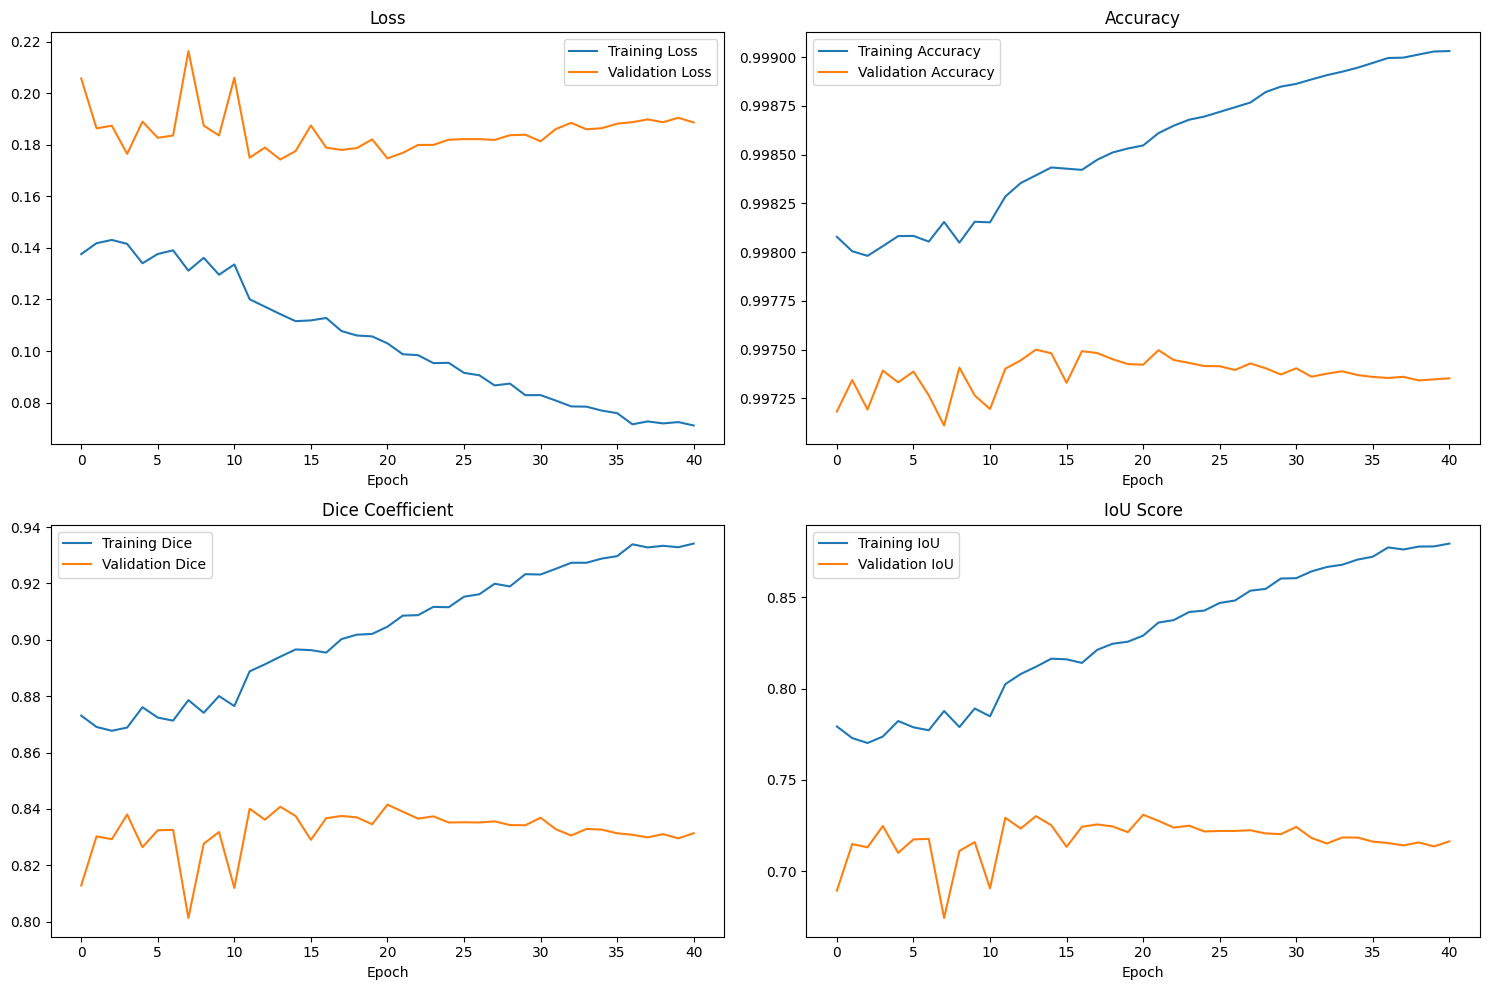

In [98]:
# ==================== PART 9: EVALUATION AND VISUALIZATION ====================
print("\n=== Training Complete ===")

# Plot training history
def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    
    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1, 0].set_title('Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    
    # IoU Score
    axes[1, 1].plot(history.history['iou_score'], label='Training IoU')
    axes[1, 1].plot(history.history['val_iou_score'], label='Validation IoU')
    axes[1, 1].set_title('IoU Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [102]:
# ==================== PART 10: FINAL EVALUATION ====================
print("\n=== Final Model Evaluation ===")

# Load best weights
model.load_weights('/kaggle/working/multiresunet_single_normalized.weights.h5')
# model.load_weights('/kaggle/input/models/multiresunet.weights.h5')
# Evaluate on validation set
#print(model.evaluate(X_test, y_test, batch_size=BATCH_SIZE))
val_loss, val_acc, val_dice, val_iou ,val_tpr, val_fpr, val_prec, val_specificity, val_f1= model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"\nValidation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"Dice Coefficient: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")
print(f"tpr Score: {val_tpr:.4f}")
print(f"fpr Score: {val_fpr:.4f}")
print(f"prec Score: {val_prec:.4f}")
print(f"specifity Score: {val_specificity:.4f}")
print(f"fl Score: {val_f1:.4f}")


=== Final Model Evaluation ===
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9970 - dice_coefficient: 0.8036 - f1_score: 0.8045 - false_positive_rate: 0.0012 - iou_score: 0.6801 - loss: 0.2217 - precision: 0.8443 - specificity: 0.9988 - true_positive_rate: 0.7813

Validation Results:
Loss: 0.1886
Accuracy: 0.9974
Dice Coefficient: 0.8314
IoU Score: 0.7164
tpr Score: 0.8174
fpr Score: 0.0012
prec Score: 0.8564
specifity Score: 0.9988
fl Score: 0.8323


In [99]:
# ==================== PART 2: LOAD DATA ====================
print("\n=== Loading Data ===")

# Load pickle files
# with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_train_Images.pkl', 'rb') as f:
#     images_train = pickle.load(f)

# with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_train_Masks.pkl', 'rb') as f:
#     masks_train = pickle.load(f)

# with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_val_Images.pkl', 'rb') as f:
#     images_val = pickle.load(f)

# with open('/kaggle/input/cx22-nucleus-fold-1/CX22_fold_1_val_Masks.pkl', 'rb') as f:
#     masks_val = pickle.load(f)

with open('/kaggle/input/nucleus-test/CX22_nucleus_test_images.pkl', 'rb') as f:
    images_test= pickle.load(f)

with open('/kaggle/input/nucleus-test/CX22_nucleus_test_masks.pkl', 'rb') as f:
    masks_test = pickle.load(f)

print(f"test data shape - Images: {images_test.shape}, Masks: {masks_test.shape}")
# print(f"Validation data shape - Images: {images_val.shape}, Masks: {masks_val.shape}")

# Normalize images to [0,1]
X_test = images_test.astype('float32')
# X_test = images_test.astype('float32') / 255.0
# X_val = images_val.astype('float32') / 255.0

# Convert masks to categorical (one-hot encoding) for num_classes=2
y_test= tf.keras.utils.to_categorical(masks_test, num_classes=2)
# y_val = tf.keras.utils.to_categorical(masks_val, num_classes=2)

print(f"\nAfter preprocessing:")
print(f"X_train: {X_test.shape}, y_train: {y_test.shape}")
# print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Unique values in masks: {np.unique(masks_test)}")


=== Loading Data ===
test data shape - Images: (100, 512, 512, 3), Masks: (100, 512, 512)

After preprocessing:
X_train: (100, 512, 512, 3), y_train: (100, 512, 512, 2)
Unique values in masks: [0 1]



=== Visualizing Predictions ===


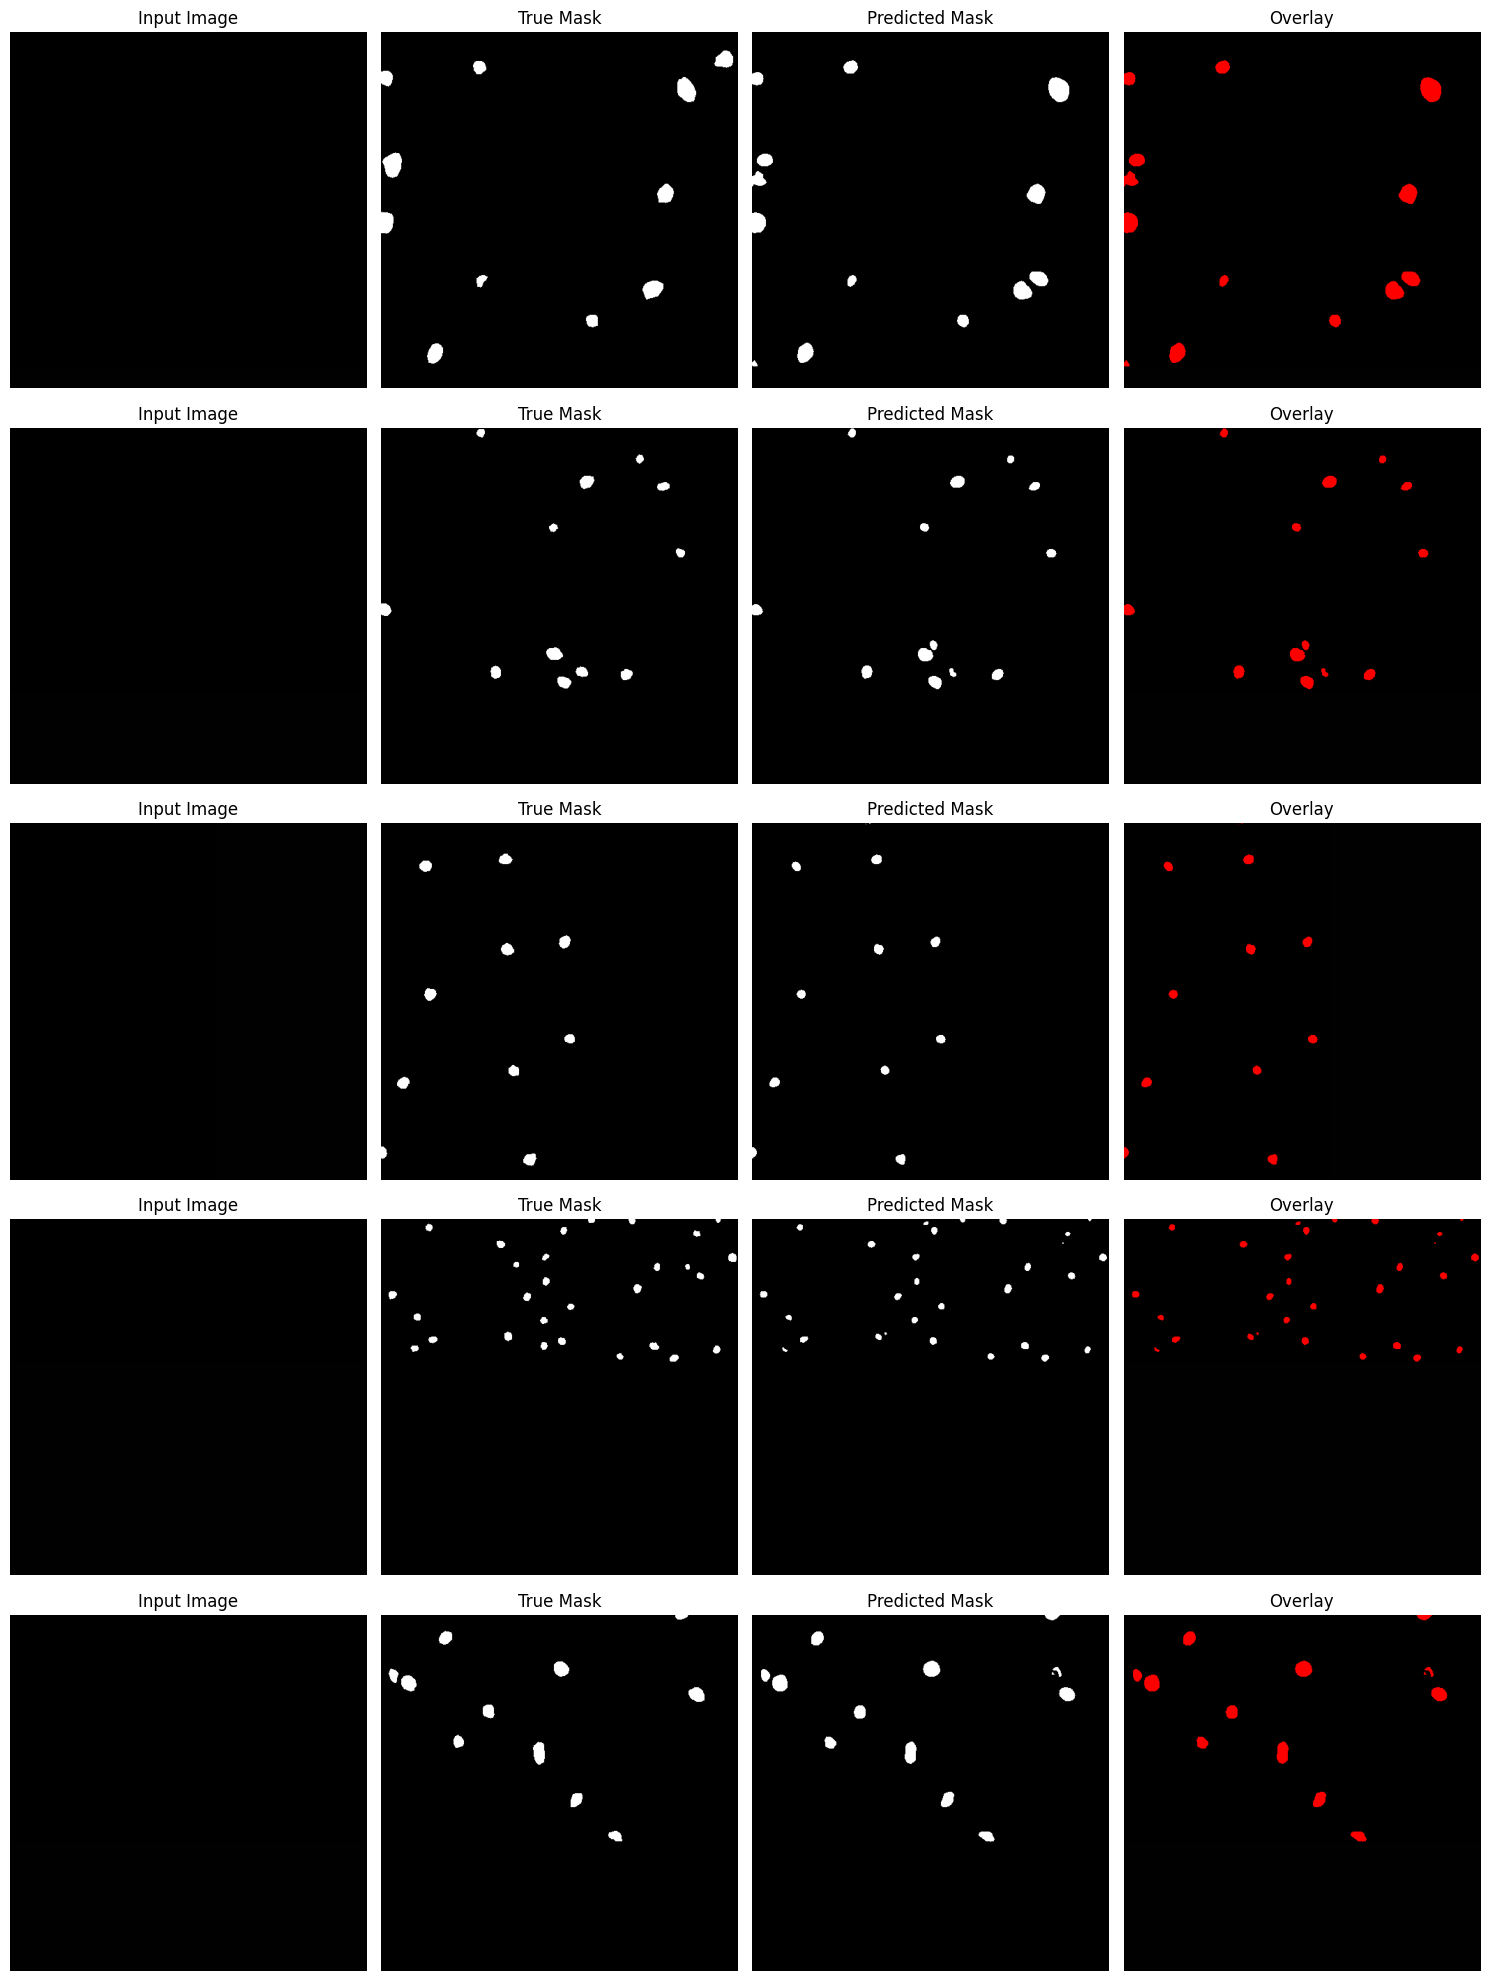

In [21]:
# ==================== PART 11: PREDICTION VISUALIZATION ====================
print("\n=== Visualizing Predictions ===")

def visualize_predictions(model, X_val, y_val, num_samples=5):
    """Visualize model predictions"""
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 4*num_samples))
    
    # Select random samples
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Get prediction
        img = X_val[idx:idx+1]
        true_mask = y_val[idx]
        pred_mask = model.predict(img, verbose=0)[0]
        
        # Convert to binary masks
        true_binary = np.argmax(true_mask, axis=-1)
        pred_binary = np.argmax(pred_mask, axis=-1)
        
        # Plot
        axes[i, 0].imshow(X_val[idx])
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_binary, cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_binary, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
        
        # Overlay
        overlay = X_val[idx].copy()
        overlay[pred_binary == 1] = [1, 0, 0]  # Red overlay
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, X_test, y_test)